Conjugate Gradients
===

The gradient method is an improvement to the Richardson method since it does not need the spectral bounds explicitly. The Chebyshev method is an improvement to the Richardson method since the number of iterations are reduced from $(\log \varepsilon^{-1}) \, \kappa$ to $(\log \varepsilon^{-1}) \, \sqrt{\kappa}$.

The conjugate gradients method combines both advantages.

All four methods need one matrix-vector multiplication with the system matrix $A$, and one preconditioner application $C^{-1}$ per iteration, plus some vector updates. The gradient method and conjugate gradient method need inner products.




The idea behind the cg-method is to minimize the Ritz functional

$$
\min_{x \in {\mathcal K}^n} \tfrac{1}{2} x^T A x - b^T x
$$

over the Krylov-space 

$$
{\mathcal K}^n = \operatorname{span} \{ C^{-1} b, C^{-1} A C^{-1} b, \ldots, (C^{-1} A)^{n-1} C^{-1} b \}.
$$

In every iteration we increase the space to minimize, and compute the new minimizer. This can be done efficiently by computing an orthogonal basis for ${\mathcal K}^n$.

Since every polynomial iteration (such as the Chebyshev method) produces iterates $x^n \in {\mathcal K}^n$, we obtain error estimates for the cg-method immediately from the Chebyshev method.

Solving the minimization problem
---
Assume an $n$-dimensional sub-space $V^n \subset {\mathbb R}^N$ is spanned by basis vectors $p_1, \ldots, p_n$. Let $P \in {\mathbb R}^{N \times n}$ contain the basis vectors $p^k$ as column vectors. We want to solve the minimization problem 

$$
\min_{x \in V^n} \tfrac{1}{2} x^T A x - b^T x.
$$

Since every $x \in V^n$ can be represented as $x = P y$ with $y \in {\mathbb R}^n$, the minimization problem can be rewritten  as:

$$
\min_{y \in {\mathbb R}^n} \tfrac{1}{2} y^T P^T A P y - b^T P y.
$$

The solution is

$$
y = (P^T A P)^{-1} P^T b,
$$

which is obtained by solving a small, $n \times n$-dimensional linear system. The original solution $x$ is 

$$
x = P (P^T A P)^{-1} P^T b
$$

If the vectors $p_i$ are $A$-orthogonal (also known as $A$-conjugate), i.e.

$$
{p_i}^T A p_j = 0 \quad \forall \, i \neq j,
$$

then the matrix $P^T A P$ is diagonal, and the minimization problem can be solved very easily:

$$
x = \sum_{i=1}^n \frac{{p_i}^T b}{{p_i}^T A p_i} p_i
$$

If we increase the space $V^n$ to $V^{n+1}$ by adding one more vector $p_{i+1}$, orthogonal to all previous $p_1, \ldots , p_n$, then the minimizer $x_{n+1}$ on $V^{n+1}$ can be updated cheaply from the minimizer $x^n$ on $V^n$:

$$
x_{n+1} = x_n + \frac{ p_{n+1}^T b}{ p_{n+1}^T A p_{n+1}} p_{n+1}
$$

Expanding the Krylov-space
---

Assume we are given the Krylov space ${\mathcal K}^n$, and we have computed the minimizer $x_n \in {\mathcal K}^n$.

The (negative) gradient of $f(x) = \tfrac{1}{2} x^T A x - b^T x$ is

$$
-\nabla f(x_n) = r_n = b - A x_n \; \bot_{{\mathbb R}^N} \; {\mathcal K}^n
$$

If $r_n = 0$, the problem is solved and we stop. 

Since $r_n$ is ${\mathbb R}^N$-orthogonal to ${\mathcal K}^n$, for 

$$
w_n := C^{-1} r_n  \qquad \text{there holds} \qquad w_n \; \bot_C \; {\mathcal K}^n
$$

This is seen as $\left< w_n, z \right>_C = \left< C w_n, z \right> = r_n^T z = 0$ for all $z \in {\mathcal K}^n$.

Since $x_n$ is in ${\mathcal K}^n$, and $w_n$ is obtained by yet another applications of $C^{-1}$ and $A$, we get $w_n \in {\mathcal K}^{n+1}$. Together with $C$-orthogonality we have

$$
{\mathcal K}^{n+1} = {\mathcal K}^n + \operatorname{span} \{ w_n \}
$$

Finally, we construct an $A$-orthogonal basis by Gram-Schmidt orthogonalization:

$$
p_{n+1} = w_n - \sum_{i=1}^n \frac{ \left<w_n, p_i\right>_A }{ \left< p_i, p_i \right>_A } p_i
$$

Here the miracle of the cg-method pops up. The inner products in the numerator are

$$
\left< w_n, p_i \right>_A = \left< C^{-1} r_n, p_i \right>_A = r_n^T C^{-1} A p_i
$$

Since $r^n \; \bot \; {\mathcal K}^n$, and $C^{-1} A p_i \in {\mathcal K}^{i+1}$, this inner product vanishes for all $i \leq n-1$. Only the last term in the sum remains:

$$
p_{n+1} = w_n - \frac{ \left<w_n, p_n\right>_A }{ \left< p_n, p_n \right>_A } p_n
$$


In Saad, "Iterative Solvers", the Preconditioned Conjugate Gradient method
is Algorithm 9.1, page 277. The inner products are reformulated by recursions which have better stability with respect to roundoff errors.

In [1]:
def CG(A,b,pre, maxit=200, tol=1e-8, callback=None):
    x = b.CreateVector()
    w = b.CreateVector()
    r = b.CreateVector()
    p = b.CreateVector()
    ap = b.CreateVector()

    r.data = b
    p.data = pre*r
    wrn = InnerProduct(r,p)
    err0 = sqrt(wrn)
    x[:] = 0
    
    for it in range(maxit):
        ap.data = A * p

        pap = InnerProduct(p, ap)
        wr = wrn
        alpha = wr / pap
        
        x.data += alpha * p
        r.data -= alpha * ap
        w.data = pre*r
        
        wrn = InnerProduct(w, r)
        err = sqrt(wrn)
        # print ("Iteration",it,"err=",err)
        if callback: callback(it,err)
        if err < tol * err0: break
            
        beta = wrn / wr
        
        p *= beta
        p.data += w 
        
    return x

In [2]:
from ngsolve import *
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1)
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(x*y*v*dx).Assemble()
gfu = GridFunction(fes)
pre = a.mat.CreateSmoother()   

In [6]:
hist=[]
gfu.vec.data = CG(a.mat, f.vec, pre,
                 callback=lambda it,err: hist.append(err))

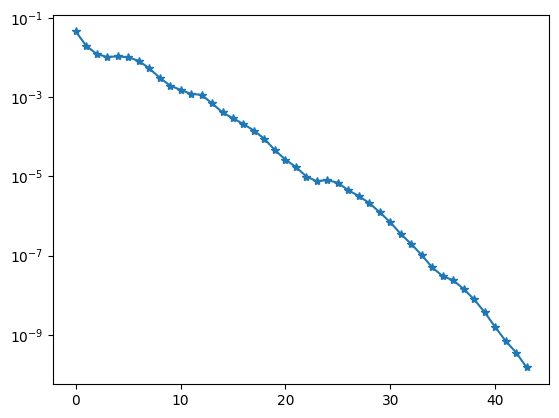

In [10]:
import matplotlib.pyplot as plt
plt.yscale('log')
plt.plot(hist, '-*');

In [11]:
from ngsolve.webgui import Draw
Draw (gfu);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…